Reloading modules sometimes causes errors. It's easier to just restart the notebook kernel and run from the start every time.

## Setup environment

In [1]:
checkpoint_dir="checkpoints"
if 'google.colab' in str(get_ipython()):
    COLAB = True
    print('Running on colab')
    %cd /content/
    !git clone https://github.com/TeamDman/Vehicular-Game-Theory
    %cd /content/Vehicular-Game-Theory/platoongame
    !git pull

    from utils import get_device
    import torch
    assert get_device() == torch.device("cuda")

    use_gdrive_checkpoints = True #@param {type:"boolean"}
    if use_gdrive_checkpoints:
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p /content/drive/MyDrive/checkpoints
        checkpoints_dir = "/content/drive/MyDrive/checkpoints"
else:
    COLAB = False
    print('Not running on colab')

Not running on colab


## Configuration

### Seed RNG

In [2]:
import random
random_seed = 42 #@param {type:"integer"}
random.seed(random_seed)
import torch
torch.manual_seed(random_seed)

### Vehicle provider config

In [3]:
from vehicles import JsonVehicleProvider, RandomVehicleProvider, RubbishVehicleProvider


provider = "random" #@param ["random", "json", "rubbish"]
if provider == "json":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "random":
  vehicle_provider=RandomVehicleProvider(
    # this affects model shape
    num_max_vulns=7 #@param {type:"integer"}
    ,
    prob_mu=0.5 #@param {type:"number"}
    ,
    prob_sigma=0.25 #@param {type:"number"}
    ,
    sev_mu=2 #@param {type:"number"}
    ,
    sev_sigma=1 #@param {type:"number"}
    ,
  )
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

### Game config

In [4]:
from game import GameConfig

game_config=GameConfig(
    max_vehicles=30 #@param {type:"integer"}
    ,
    cycle_every=1 #@param {type:"integer"}
    ,
    cycle_allow_platoon=False #@param {type:"boolean"}
    ,
    cycle_num=10 #@param {type:"integer"}
)

### Attacker agent config

In [5]:
from agents import PassiveAgent, BasicAttackerAgent

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  attacker = BasicAttackerAgent(1)
else:
  raise ValueError("unknown attacker chosen")

### Defender agent config

In [6]:
from agents import WolpertingerDefenderAgent
from models import StateShapeData
from vehicles import Vehicle, Vulnerability

load_checkpoint = False #@param {type:"boolean"}

defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001 #@param {type:"number"}
    ,
    num_proposals=3 #@param {type: "integer"}
    ,
)

if load_checkpoint:
  defender.load(
    dir=checkpoints_dir,
    prefix="2022-10-13 2258-27 054659" #@param {type: "string"}
)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Replay memory config

In [7]:
from memory import DequeReplayMemory

memory = DequeReplayMemory(
    capacity=10000 #@param {type:"integer"}
)

### Training metrics tracker config

In [8]:
from metrics import TrainingMetricsTracker
tracker = TrainingMetricsTracker()

### Evaluation config

In [9]:
from evaluation import ModelEvaluator
evaluator = ModelEvaluator(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    memory=memory
)

## Baseline metrics

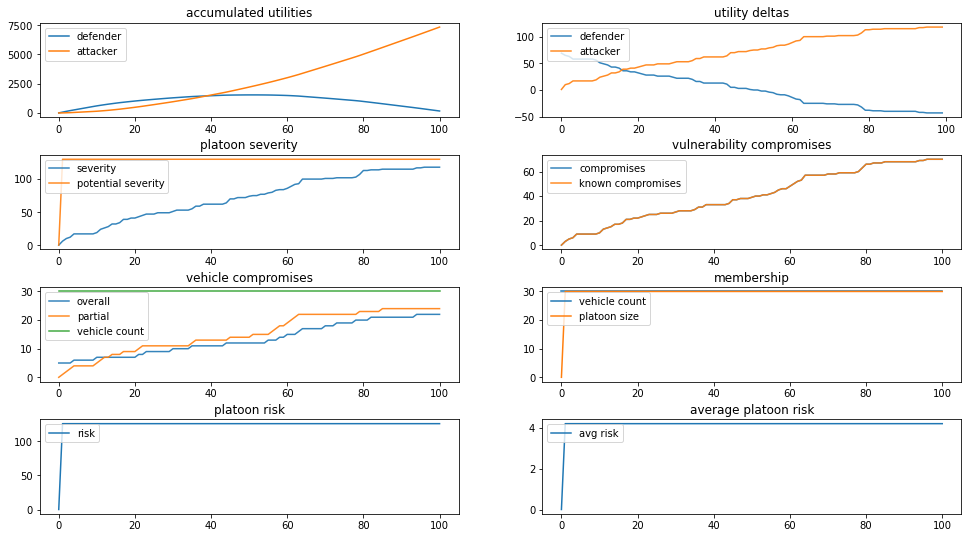

In [10]:
evaluator.get_episode_metrics(
    num_turns=100 #@param {type:"integer"}
).plot()

## Training

### Trainer config

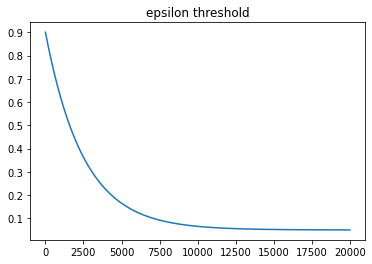

In [19]:
#@title Trainer
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    checkpoint_interval=-1 #@param {type:"integer"}
    ,
    memory=memory,
    metrics_tracker=tracker,
    batch_size=2000 #@param {type:"integer"}
    ,
    train_steps=50 #@param {type:"integer"}
    ,
    train_interval=5 #@param {type:"integer"}
    ,
    warmup_replay=4000 #@param {type:"integer"}
    ,
    max_steps_per_episode=50 #@param {type:"integer"}
    ,
    update_policy_interval=10 #@param {type:"integer"}
    ,
    policy_update_type="soft" #@param ["soft", "hard"]
    ,
    reward_gamma = 0.99 #@param {type:"number"}
    ,
    soft_update_tau = 0.001 #@param {type:"number"}
    ,
    epsilon_start = 0.9 #@param {type:"number"}
    ,
    epsilon_end = 0.05 #@param {type:"number"}
    ,
    epsilon_decay = 2500 #@param {type:"number"}
    ,
))
trainer.plot_epsilon_threshold(num_steps=20000)

### Perform training

In [11]:
trainer.train()

Warming up...


  0%|          | 0/40 [00:00<?, ?it/s]

Warmup complete~!
2022-10-13 1721-24 536570 episode 2 step 15 optimizing loss=350.7120 diff={max=37.8150, min=1.1850, mean=16.4052} policy_loss=2.1930 policy updated! 
2022-10-13 1721-24 705573 episode 2 step 16 optimizing loss=309.6759 diff={max=35.2217, min=3.7783, mean=15.6207} policy_loss=6.3570 
2022-10-13 1721-24 843572 episode 2 step 17 optimizing loss=212.1277 diff={max=29.0951, min=1.0951, mean=11.9664} policy_loss=2.2164 
2022-10-13 1721-24 947575 episode 2 step 18 optimizing loss=235.3042 diff={max=39.2018, min=0.2018, mean=12.6164} policy_loss=3.5746 
2022-10-13 1721-25 049572 episode 2 step 19 optimizing loss=240.5290 diff={max=38.5236, min=0.4764, mean=11.4291} policy_loss=6.2112 
2022-10-13 1721-25 150569 episode 2 step 20 optimizing loss=255.6790 diff={max=31.9180, min=0.0515, mean=11.4733} policy_loss=6.4660 
2022-10-13 1721-25 249572 episode 2 step 21 optimizing loss=148.2459 diff={max=31.2097, min=0.4334, mean=7.6129} policy_loss=2.5676 
2022-10-13 1721-25 356570 epi

### View training metrics

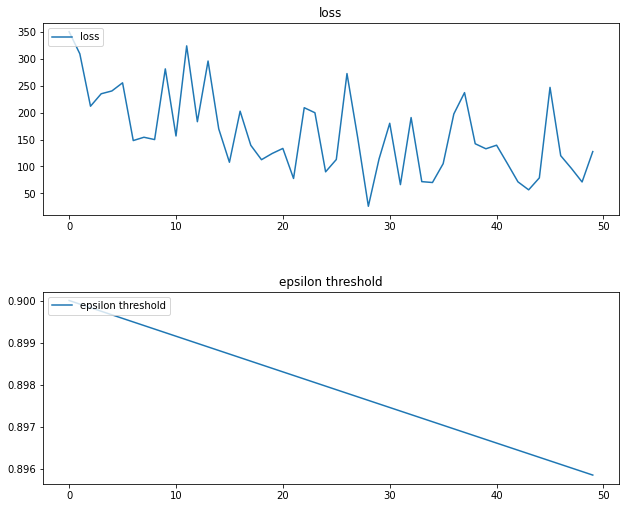

In [13]:
tracker.plot()

## Evaluation

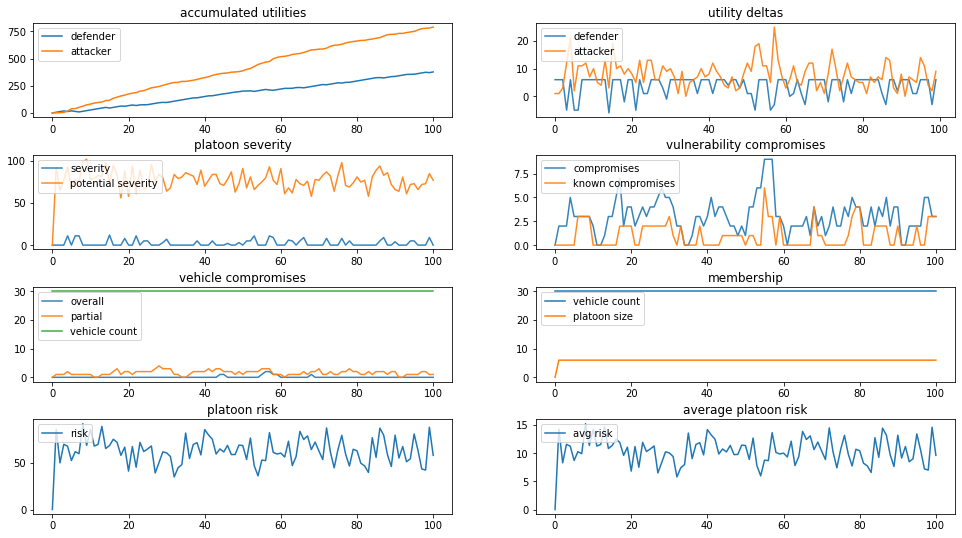

In [14]:
evaluator.get_episode_metrics(
    num_turns=100 #@param {type:"integer"}
).plot()

In [15]:
evaluator.sample_model_outputs()

action.members tensor([[1.8775e-25, 2.2620e-10, 7.4650e-23, 1.0000e+01, 2.6479e-27, 4.5342e-15,
         1.2685e-33, 1.0000e+01, 2.7526e-16, 1.7223e-18, 8.3992e-12, 1.3653e-30,
         5.9171e-25, 4.3497e-12, 6.5520e-26, 1.0000e+01, 2.2497e-21, 2.7756e-13,
         2.0873e-20, 1.1835e-32, 4.9318e-22, 1.0000e+01, 1.9962e-34, 9.8227e-35,
         1.6352e-25, 1.0000e+01, 7.2719e-13, 8.5065e-27, 1.0000e+01, 3.9362e-16]],
       grad_fn=<SumBackward1>)
q_pred tensor([ 7.6854,  5.4475, -6.9996, -6.9996,  4.3640, -6.9996,  1.9386,  4.6268,
         7.2915,  6.2195], grad_fn=<ReshapeAliasBackward0>)
batch.reward tensor([  6.,   6., -18.,   0.,   6., -21.,  -2.,   3.,   6.,   2.])
pred reward err tensor([ 1.6854, -0.5525, 11.0004, -6.9996, -1.6360, 14.0004,  3.9386,  1.6268,
         1.2915,  4.2195], grad_fn=<SubBackward0>)


## Manually checkpoint model

In [12]:
from utils import get_prefix

manual_checkpoint = False #@param {type:"boolean"}
if manual_checkpoint:
    prefix = get_prefix()
    defender.save(dir=checkpoints_dir, prefix=prefix)
    trainer.config.dump(dir=checkpoints_dir, prefix=prefix)
    print(prefix)